In [1]:
!pip install casadi

import casadi
from casadi import *
import numpy

from matplotlib import pyplot as plt, rc
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
rc('animation', html='jshtml')

# Dark mode plots ;)
!pip install jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

from ipywidgets import IntProgress
from IPython.display import display

     |████████████████████████████████| 21.2 MB 3.2 MB/s            
     |████████████████████████████████| 7.0 MB 4.4 MB/s            
     |████████████████████████████████| 46 kB 2.1 MB/s            
     |████████████████████████████████| 49 kB 1.3 MB/s            


In [2]:
g = 9.8
m = 100000 # kg
min_thrust = 880 * 1000 # N
max_thrust = 1 * 2210 * 1000 #kN

length = 50 # m 
width = 10

# Inertia for a uniform density rod 
I = (1/12) * m * length**2

deg_to_rad = 0.01745329

max_gimble = 20  * deg_to_rad
min_gimble = -max_gimble

# x[0] = x position (m)
# x[1] = x velocity (m/)
# x[2] = y position (m)
# x[3] = y velocity (m/s)
# x[4] = angle (rad)
# x[5] = angular velocity (rad/s)

# u[0] = thrust (percent)
# u[1] = thrust angle (rad)

def x_dot(x, u):
    theta = x[4]
    
    thrust = u[0]
    thrust_angle = u[1]
    
    # Horizontal force
    F_x = max_thrust * thrust * sin(thrust_angle + theta)
    x_dot = x[1]
    x_dotdot = (F_x) / m
        
    # Vertical force
    F_y = max_thrust * thrust * cos(thrust_angle + theta)
    y_dot = x[3]
    y_dotdot = (F_y) / m - g
    
    # Torque
    T = -length/2 * max_thrust * thrust * sin(thrust_angle)
    theta_dot = x[5]
    theta_dotdot = T / I
    
    return [x_dot, x_dotdot, y_dot, y_dotdot, theta_dot, theta_dotdot]

In [3]:
# Make an optemization problem
opti = casadi.Opti()

# Set the number of steps and the timestep (dt)
steps = 400
t_step = 0.04

# Generate the array of state and control vectors
x = opti.variable(steps, 6)
u = opti.variable(steps, 2)
# t_step = opti.variable(1, 1)

# opti.subject_to( opti.bounded(0.01, t_step, 0.2))

x[0, :] = [0, 0, 1000, -80, -np.pi/2, 0]
x[steps-1, :] = [0, 0, 0, 0, 0, 0]

# u[steps-1, 1] = 0

# Cost function
opti.minimize(sumsqr(u[:, 0]) +  sumsqr(u[:, 1]) + 2 * sumsqr(x[:, 5]))

# Set dynamics constraints
for i in range(0, steps-1):
    opti.subject_to( x[i+1, 0] - x[i, 0] == x_dot(x[i, :], u[i, :])[0] * t_step )
    opti.subject_to( x[i+1, 1] - x[i, 1] == x_dot(x[i, :], u[i, :])[1] * t_step )
    
    opti.subject_to( x[i+1, 2] - x[i, 2] == x_dot(x[i, :], u[i, :])[2] * t_step )
    opti.subject_to( x[i+1, 3] - x[i, 3] == x_dot(x[i, :], u[i, :])[3] * t_step )
    
    opti.subject_to( x[i+1, 4] - x[i, 4] == x_dot(x[i, :], u[i, :])[4] * t_step )
    opti.subject_to( x[i+1, 5] - x[i, 5] == x_dot(x[i, :], u[i, :])[5] * t_step )

# Set bounds constraints
for i in range(0, steps):
    opti.subject_to( opti.bounded(0.4, u[i, 0], 1))
    opti.subject_to( opti.bounded(min_gimble, u[i, 1], max_gimble))

# Select solver
opti.solver('ipopt')

# Solve! Might take ~ 20 seconds
sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     9160
Number of nonzeros in inequality constraint Jacobian.:      800
Number of nonzeros in Lagrangian Hessian.............:     2791

Total number of variables............................:     3200
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

  87r 1.6316685e+02 9.02e+02 1.89e+01  -1.2 6.82e-01   1.4 1.00e+00 1.00e+00f  1
  88r 1.6370515e+02 9.01e+02 1.87e+01  -1.2 2.00e+00   1.0 6.74e-01 4.46e-01f  1
  89r 1.6389502e+02 9.00e+02 1.86e+01  -1.2 7.52e-01   1.4 1.00e+00 5.09e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r 1.6451128e+02 9.00e+02 1.84e+01  -1.2 2.20e+00   0.9 3.53e-01 3.57e-01f  1
  91r 1.6483999e+02 8.99e+02 1.83e+01  -1.2 8.32e-01   1.3 1.00e+00 7.49e-01f  1
  92r 1.6519240e+02 8.98e+02 1.82e+01  -1.2 2.42e+00   0.9 5.21e-01 2.25e-01f  1
  93r 1.6561276e+02 8.98e+02 1.79e+01  -1.2 9.18e-01   1.3 1.00e+00 1.00e+00f  1
  94r 1.6580822e+02 8.97e+02 1.78e+01  -1.2 3.43e-01   1.7 1.00e+00 1.00e+00f  1
  95r 1.6611460e+02 8.97e+02 1.77e+01  -1.2 1.02e+00   1.2 1.00e+00 5.12e-01f  1
  96r 1.6626752e+02 8.96e+02 1.76e+01  -1.2 3.81e-01   1.7 1.00e+00 7.81e-01f  1
  97r 1.6678246e+02 8.95e+02 1.73e+01  -1.2 1.13e+00   1.2 6.49e-01 1.00e+00f  1
  98  1.6678248e+02 8.95e+02

 189r 1.8132253e+02 7.59e+02 3.53e+01  -0.6 7.67e-01   1.4 7.58e-01 1.94e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190r 1.8172239e+02 7.59e+02 2.07e+01  -0.6 2.89e-01   1.9 1.00e+00 9.25e-01f  1
 191r 1.8211155e+02 7.59e+02 2.97e+01  -0.6 8.64e-01   1.4 7.76e-01 2.96e-01f  1
 192r 1.8229731e+02 7.59e+02 2.02e+01  -0.6 3.08e-01   1.8 1.00e+00 4.92e-01f  1
 193r 1.8277902e+02 7.59e+02 2.19e+01  -0.6 9.15e-01   1.3 7.14e-01 3.83e-01f  1
 194r 1.8320638e+02 7.59e+02 1.89e+01  -0.6 3.56e-01   1.8 1.00e+00 8.79e-01f  1
 195r 1.8346847e+02 7.59e+02 2.11e+01  -0.6 9.73e-01   1.3 4.96e-01 1.82e-01f  1
 196r 1.8383833e+02 7.59e+02 1.85e+01  -0.6 3.62e-01   1.7 1.00e+00 7.54e-01f  1
 197r 1.8450420e+02 7.59e+02 1.83e+01  -0.6 1.08e+00   1.2 5.01e-01 3.46e-01f  1
 198r 1.8472905e+02 7.59e+02 1.80e+01  -0.6 3.83e-01   1.7 1.00e+00 3.71e-01f  1
 199r 1.8490795e+02 7.59e+02 1.74e+01  -0.6 1.43e-01   2.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 287r 2.0613768e+02 7.49e+02 1.20e+01  -1.3 2.75e-01   1.6 1.00e+00 9.76e-01f  1
 288r 2.0626999e+02 7.48e+02 1.20e+01  -1.3 8.26e-01   1.2 2.70e-01 2.93e-01f  1
 289r 2.0638395e+02 7.48e+02 1.20e+01  -1.3 3.10e-01   1.6 1.00e+00 5.90e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290r 2.0653943e+02 7.48e+02 1.20e+01  -1.3 9.29e-01   1.1 6.67e-01 2.06e-01f  1
 291r 2.0678527e+02 7.48e+02 1.20e+01  -1.3 3.48e-01   1.5 1.00e+00 1.00e+00f  1
 292r 2.0711146e+02 7.47e+02 1.20e+01  -1.3 1.04e+00   1.1 4.70e-01 1.89e-01f  1
 293r 2.0720075e+02 7.47e+02 1.96e+01  -1.3 3.92e-01   1.5 1.00e+00 3.05e-01f  1
 294r 2.0749611e+02 7.47e+02 1.20e+01  -1.3 1.17e+00   1.0 2.68e-01 3.79e-01f  1
 295r 2.0767257e+02 7.47e+02 1.20e+01  -1.3 4.41e-01   1.4 1.00e+00 6.39e-01f  1
 296r 2.0802415e+02 7.46e+02 1.20e+01  -1.3 2.29e+00   1.0 1.68e-01 1.32e-01f  1
 297r 2.0819607e+02 7.46e+02 1.20e+01  -1.3 4.98e-01   1.4 1.00e+00 5.20e-01f  1
 298r 2.0825402e+02 7.46e+02

 387r 2.2410484e+02 7.07e+02 1.16e+01  -1.3 1.50e+00   0.9 2.02e-01 6.50e-01f  1
 388r 2.2417506e+02 7.07e+02 1.16e+01  -1.3 5.63e-01   1.3 1.00e+00 7.72e-01f  1
 389r 2.2448063e+02 7.06e+02 1.16e+01  -1.3 1.68e+00   0.8 8.15e-01 6.17e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390r 2.2448063e+02 7.06e+02 9.99e+02   2.8 0.00e+00   1.4 0.00e+00 3.15e-07R  4
 391r 2.1867427e+02 7.06e+02 9.99e+02   2.8 1.16e+04    -  9.30e-06 5.13e-05f  1
 392r 2.1814823e+02 7.05e+02 9.94e+02   0.8 1.51e+02    -  4.80e-01 4.89e-03f  1
 393r 2.1844365e+02 7.05e+02 9.93e+02   0.8 6.24e+02    -  1.76e-02 1.51e-03f  1
 394r 2.2618560e+02 6.68e+02 9.31e+02   0.8 5.85e+02    -  6.01e-02 6.21e-02f  1
 395r 2.2980938e+02 6.67e+02 8.76e+02   0.8 2.63e+01   0.0 7.80e-02 6.16e-02f  1
 396r 2.3562646e+02 6.63e+02 8.72e+02   0.8 7.56e+02    -  6.92e-03 4.46e-03f  1
 397r 2.4773645e+02 6.55e+02 8.65e+02   0.8 1.10e+03    -  5.08e-03 7.26e-03f  1
 398r 2.5711182e+02 6.49e+02

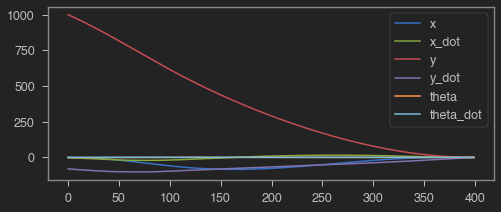

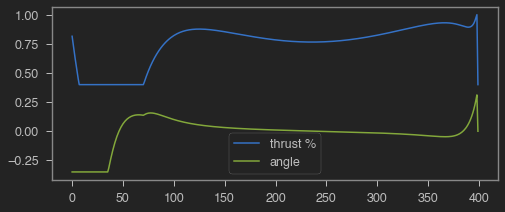

In [4]:
# Plot state
plt.subplot(211)
plt.plot(sol.value(x)[:, 0], label = "x")
plt.plot(sol.value(x)[:, 1], label = "x_dot")
plt.plot(sol.value(x)[:, 2], label = "y")
plt.plot(sol.value(x)[:, 3], label = "y_dot")
plt.plot(sol.value(x)[:, 4], label = "theta")
plt.plot(sol.value(x)[:, 5], label = "theta_dot")
plt.legend()
plt.show()

# Plot control input
plt.subplot(212)
plt.plot(sol.value(u)[:, 0], label = "thrust %")
plt.plot(sol.value(u)[:, 1], label = "angle")
plt.legend()
plt.show()

final_time_step = sol.value(t_step);
duration = sol.value(t_step) * steps

Generating Animation


IntProgress(value=0, max=400)

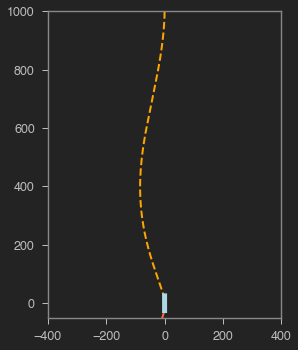

In [5]:
print("Generating Animation")
f = IntProgress(min = 0, max = steps)
display(f)

x_t = sol.value(x)
u_t = sol.value(u)

fig = plt.figure(figsize = (5, 5), constrained_layout=False)

ax1 = fig.add_subplot(111)

ln6, = ax1.plot([], [], '--', linewidth = 2, color = 'orange')

ln2, = ax1.plot([], [], linewidth = 2, color = 'tomato')
ln1, = ax1.plot([], [], linewidth = 5, color = 'lightblue')

#plt.axis('off')
plt.tight_layout()

ax1.set_xlim(-400, 400)
ax1.set_ylim(-50, 1000)
ax1.set_aspect(1)

def update(i):
  rocket_theta = x_t[i, 4]

  rocket_x = x_t[i, 0]
  rocket_x_points = [rocket_x + length/2 * sin(rocket_theta), rocket_x - length/2 * sin(rocket_theta)]

  rocket_y = x_t[i, 2]
  rocket_y_points = [rocket_y + length/2 * cos(rocket_theta), rocket_y - length/2 * cos(rocket_theta)]

  ln1.set_data(rocket_x_points, rocket_y_points)


  thrust_mag = u_t[i, 0]
  thrust_angle = -u_t[i, 1]

  flame_length = (thrust_mag) * 50


  flame_x_points = [rocket_x_points[1], rocket_x_points[1] + flame_length * sin(thrust_angle - rocket_theta)]
  flame_y_points = [rocket_y_points[1], rocket_y_points[1] - flame_length * cos(thrust_angle - rocket_theta)]

  ln2.set_data(flame_x_points, flame_y_points)

  ln6.set_data(x_t[:i, 0], x_t[:i, 2])

  f.value += 1

anim = FuncAnimation(fig, update, np.arange(0, steps-1, 1), interval= final_time_step * 1000)

anim

In [18]:
import scipy.io as sio
# Create a dictionary
# adict = {}
# adict['sol.value'] = sol.value(x)
# sio.savemat('test.mat', adict)
numpy.savetxt("reference_traj.csv",sol.value(x) , delimiter=",")

In [14]:
print(type(sol.value(x)))

<class 'numpy.ndarray'>
